In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader, random_split

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
BATCH_SIZE = 128

# Prepare dataset and preprocessing
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),      # Augmentation
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))    # Normalization for RGB images
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))    # Same normalization for test set
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)



Files already downloaded and verified
Files already downloaded and verified


In [5]:
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
classes

('airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck')

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):
        out = self.left(x)
        out = out + self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=10):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),  # Adjusted for RGB images
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
        
        # Dropout before fully connected layer
        self.dropout = nn.Dropout(p=0.5)  # Set dropout probability (e.g., 0.5)
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = F.dropout(out, p=0.3, training=self.training)  # Dropout after layer1
        out = self.layer2(out)
        out = F.dropout(out, p=0.3, training=self.training)  # Dropout after layer2
        out = self.layer3(out)
        out = F.dropout(out, p=0.3, training=self.training)  # Dropout after layer3
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        
        # Apply dropout before fully connected layer
        out = self.dropout(out)
        
        out = self.fc(out)
        return out

def ResNet18():
    return ResNet(ResidualBlock)



In [7]:
net = ResNet18().to(device)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.95, weight_decay=5e-4)

In [9]:
all_iteration_losses = []
for epoch in range(10):
    print('\nEpoch: %d' % (epoch + 1))
    net.train()
    sum_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward & backward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Store the loss for this iteration
        all_iteration_losses.append(loss.item())

        # Calculate accuracy and accumulate loss
        sum_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Print every 50 iterations
        if (i + 1) % 50 == 0:
            print('[epoch:%d, iter:%d] Loss: %.03f | Acc: %.3f%% '
                  % (epoch + 1, (i + 1), sum_loss / (i + 1), 100. * correct / total))

    # Test after each epoch
    print('Testing...')
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print('Test Accuracy: %.3f%%' % (100 * correct / total))

print('Training complete.')


Epoch: 1
[epoch:1, iter:50] Loss: 2.277 | Acc: 15.109% 
[epoch:1, iter:100] Loss: 2.093 | Acc: 20.727% 
[epoch:1, iter:150] Loss: 2.001 | Acc: 23.984% 
[epoch:1, iter:200] Loss: 1.928 | Acc: 26.867% 
[epoch:1, iter:250] Loss: 1.868 | Acc: 29.172% 
[epoch:1, iter:300] Loss: 1.820 | Acc: 31.128% 
[epoch:1, iter:350] Loss: 1.777 | Acc: 32.877% 
Testing...
Test Accuracy: 40.180%

Epoch: 2
[epoch:2, iter:50] Loss: 1.433 | Acc: 46.922% 
[epoch:2, iter:100] Loss: 1.403 | Acc: 48.484% 
[epoch:2, iter:150] Loss: 1.385 | Acc: 49.026% 
[epoch:2, iter:200] Loss: 1.361 | Acc: 49.801% 
[epoch:2, iter:250] Loss: 1.339 | Acc: 50.638% 
[epoch:2, iter:300] Loss: 1.325 | Acc: 51.151% 
[epoch:2, iter:350] Loss: 1.304 | Acc: 51.913% 
Testing...
Test Accuracy: 46.760%

Epoch: 3
[epoch:3, iter:50] Loss: 1.118 | Acc: 59.875% 
[epoch:3, iter:100] Loss: 1.095 | Acc: 60.430% 
[epoch:3, iter:150] Loss: 1.081 | Acc: 60.969% 
[epoch:3, iter:200] Loss: 1.072 | Acc: 61.289% 
[epoch:3, iter:250] Loss: 1.059 | Acc: 61

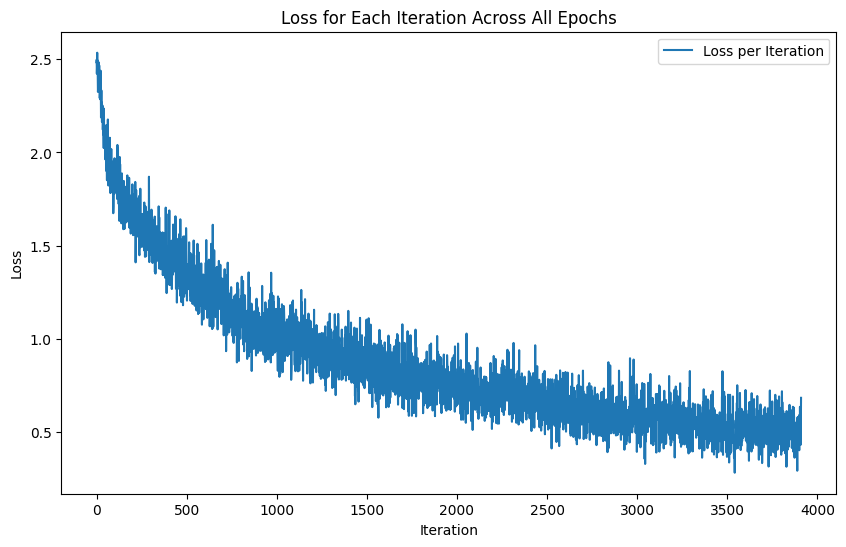

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 6))
plt.plot(all_iteration_losses, label='Loss per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss for Each Iteration Across All Epochs')
plt.legend()
plt.show()

